In [2]:
from PIL import Image
from pathlib import Path
import json
import imagehash
from bitarray import bitarray
import numpy as np
import tqdm
import matplotlib.pyplot as plt

### db

In [3]:
DB_PATH = Path('../../backend/flask-app/storage/images/')
json_path ='../../backend/flask-app/storage/records.json'
with open(json_path) as f:
    db_data = json.load(f)
res = []
for o in db_data:
    res.append((o['object_id'],
                bitarray(o['aHash']),
                bitarray(o['pHash']),
                bitarray(o['dHash']),
                bitarray(o['wHash'])))
object_id, ahash, phash, dhash, whash = zip(*res)
db = {
    'object_id': object_id,
#     'ahash': ahash,
#     'phash': phash,
#     'dhash': dhash,
#     'whash': whash,
}

In [4]:
hash_opts = [
    (imagehash.average_hash, 'ahash'),
    (imagehash.phash, 'phash'),
    (imagehash.dhash, 'dhash'),
    (imagehash.whash, 'whash'),
]

def rgb_hfunc(hfunc, image):
    def hash_and_str(image):
        return ''.join(list(hfunc(image).hash.flatten().astype(int).astype(str)))
    def newhfunc(image):
        npimage = np.asarray(image)
        res = ''
        for c in [0, 1, 2]:
            oc = npimage[:,:,c]
            npoc = np.tile(oc, 3)
            new_image = Image.fromarray(npoc)
            res += hash_and_str(new_image)
        return bitarray(res)
    return newhfunc(image)

def hash_object_id(object_id):
    image_path = DB_PATH / (object_id + '.jpg')
    image = Image.open(image_path)
    res = []
    for hfunc, nfunc in hash_opts:
        res.append(rgb_hfunc(hfunc, image))
    return res

In [5]:
res = [hash_object_id(o) for o in tqdm.tqdm(db['object_id'])]

100%|██████████| 8148/8148 [1:04:56<00:00,  2.17it/s]


In [6]:
ahash, phash, dhash, whash = zip(*res)
db['ahash'] = ahash
db['phash'] = phash
db['dhash'] = dhash
db['whash'] = whash

In [42]:
def ba_to_str(ba):
    return ''.join(list(np.array(ba.tolist()).astype(int).astype(str)))

In [43]:
new_db = db.copy()
new_db['ahash'] = [ba_to_str(o) for o in new_db['ahash']]
new_db['phash'] = [ba_to_str(o) for o in new_db['phash']]
new_db['dhash'] = [ba_to_str(o) for o in new_db['dhash']]
new_db['whash'] = [ba_to_str(o) for o in new_db['whash']]

with open('../../backend/flask-app/storage/rgb_records.json', 'w') as f:
    json.dump(new_db, f)

### pic

In [7]:
PIC_PATH = Path('../dataset/images')

In [8]:
true_map_path = '../annotation/true_map.csv'
with open(true_map_path) as f:
    true_map_raw = f.read()
true_map = [o.split(',') for o in true_map_raw.split('\n')][:-1]
name, object_id = zip(*true_map)
pic = {
    'name': name,
    'object_id': object_id,
}

In [9]:
crop_path = '../annotation/crop.txt'
with open(crop_path) as f:
    crop_raw = f.read()
crop_lines = crop_raw.split('\n')[:-1]
def split_line(line):
    com = line.index(',')
    name = line[:com]
    crops = line[com+1:]
    l1, l2, l3 = crops.split(',{')
    l1 = json.loads(l1)
    l2 = json.loads('{' + l2)
    l3 = json.loads('{' + l3)
    return name,l1,l2,l3
crops = [split_line(o) for o in crop_lines]

In [10]:
# combine
dic = {name: i for i,name in enumerate(pic['name'])}
l1s = [None] * len(pic['name'])
l2s = [None] * len(pic['name'])
l3s = [None] * len(pic['name'])
for name, l1, l2, l3 in crops:
    i = dic[name]
    l1s[i] = l1;l2s[i] = l2;l3s[i] = l3
pic['l1'] = l1s;pic['l2'] = l2s;pic['l3'] = l3s

# test crop

In [13]:
 # (left, upper, right, lower)-tuple.
def to_box(image, crop):
    width, height = image.size
    x, y, w, h = crop['x']/100, crop['y']/100, crop['width']/100, crop['height']/100
    x1 = int(x * width)
    y1 = int(y * height)
    x2 = int((x + w) * width) - 1
    y2 = int((y + h) * height) - 1
    return (x1, y1, x2, y2)

In [16]:
def get_matched_index(i, hfunc, nfunc, level):
    name = pic['name'][i]
    image_path = PIC_PATH / name
    image = Image.open(image_path)
    crop = pic[level][i]
    target_id = pic['object_id'][i]
    #
    c_image = image.crop(to_box(image, crop))
    c_image.load()
#     raw_hash = ''.join(list(rgb_hfunc(hfunc, c_image).hash.flatten().astype(int).astype(str)))
#     h = bitarray(raw_hash)
    h = rgb_hfunc(hfunc, c_image)
    #
    idx = np.argsort([(h ^ h1).count(1) for h1 in db[nfunc]])
    matched = [db['object_id'][i] for i in idx]
    return matched.index(target_id), matched

In [17]:
hash_opts = [
    (imagehash.average_hash, 'ahash'),
    (imagehash.phash, 'phash'),
    (imagehash.dhash, 'dhash'),
    (imagehash.whash, 'whash'),
]
l_opts = ['l1', 'l2', 'l3']
midx_dict = {}
for hfunc, nfunc in hash_opts:
    for l in l_opts:
        print(nfunc, l)
        midx = []; marray = []
        for i in tqdm.tqdm(list(range(len(pic['name'])))):
            mi, ma = get_matched_index(i, hfunc, nfunc, l)
            midx.append(mi)
            marray.append(ma)
        midx = np.array(midx)
        marray = np.array(marray)
        midx_dict[(nfunc, l)] = (midx, marray)

  0%|          | 0/108 [00:00<?, ?it/s]

ahash l1


  0%|          | 0/108 [00:00<?, ?it/s]

ahash l2


  0%|          | 0/108 [00:00<?, ?it/s]

ahash l3


  0%|          | 0/108 [00:00<?, ?it/s]

phash l1


  0%|          | 0/108 [00:00<?, ?it/s]

phash l2


  0%|          | 0/108 [00:00<?, ?it/s]

phash l3


  0%|          | 0/108 [00:00<?, ?it/s]

dhash l1


  0%|          | 0/108 [00:00<?, ?it/s]

dhash l2


  0%|          | 0/108 [00:00<?, ?it/s]

dhash l3


  0%|          | 0/108 [00:00<?, ?it/s]

whash l1


  0%|          | 0/108 [00:00<?, ?it/s]

whash l2


  0%|          | 0/108 [00:00<?, ?it/s]

whash l3


100%|██████████| 108/108 [02:00<00:00,  1.67s/it]


In [18]:
for hfunc, nfunc in hash_opts:
    for l in l_opts:
        print(nfunc, l)
        midx = midx_dict[(nfunc, l)][0]
        print(np.sum(midx==0), np.sum(midx<5), np.sum(midx<10))

ahash l1
51 70 76
ahash l2
63 72 76
ahash l3
60 70 75
phash l1
60 83 90
phash l2
75 92 93
phash l3
65 81 87
dhash l1
39 56 64
dhash l2
44 64 70
dhash l3
51 65 69
whash l1
48 67 71
whash l2
59 68 76
whash l3
61 72 76


## vis

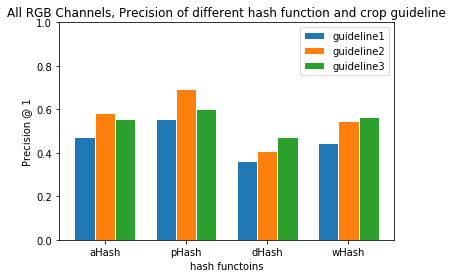

In [47]:
def plot(K=1):
    barWidth = 0.25
    bars1 = []
    bars2 = []
    bars3 = []
    for hfunc, nfunc in hash_opts:
        midx1 = midx_dict[(nfunc, 'l1')][0]
        bars1.append(np.sum(midx1 < K)/108)
        midx2 = midx_dict[(nfunc, 'l2')][0]
        bars2.append(np.sum(midx2 < K)/108)
        midx3 = midx_dict[(nfunc, 'l3')][0]
        bars3.append(np.sum(midx3 < K)/108)
    #
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    #
    plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='guideline1')
    plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='guideline2')
    plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='guideline3')
    # Add xticks on the middle of the group bars
    plt.xlabel('hash functoins')
    plt.ylabel('Precision @ {}'.format(K))
    plt.xticks([r + barWidth for r in range(len(bars1))], ['aHash', 'pHash', 'dHash', 'wHash'])

    # Create legend & Show graphic
    plt.title('All RGB Channels, Precision of different hash function and crop guideline')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()
plot(1)

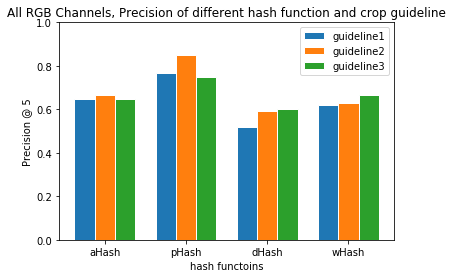

In [48]:
plot(5)

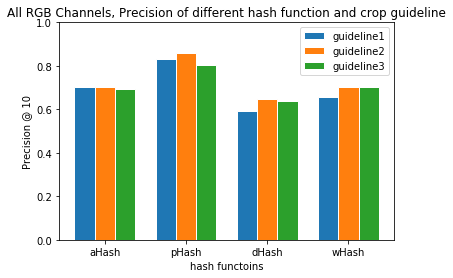

In [49]:
plot(10)